# Feature Engineering

## Imports

In [1]:
import os
import re
import yaml
import random
import gensim

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy.sparse import save_npz
from nltk.corpus import opinion_lexicon
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec, FastText,Doc2Vec 

import sys
sys.path.append("../")
from src.feature_engineering import *
from src.utility import *

## Loading Config

In [2]:
with open("../config.yaml") as f:
    config = yaml.safe_load(f)
    config = config["feature_engineering"]
fix_config_types(config)
config

{'use_gpu': True,
 'random_seed': 42,
 'save_after_each_stage': True,
 'format': 'pkl',
 'cleaned_data': 'data/interim/IMDB_cleaned.pkl',
 'save_df_path': 'data/interim/IMDB_feature_engineered.pkl',
 'label_encoder': {'save_path': 'models/label_encoder.pkl'},
 'count_vectorizer': {'encoding': 'utf-8',
  'decode_error': 'strict',
  'strip_accents': None,
  'ngram_range': (1, 3),
  'analyzer': 'word',
  'max_df': 0.9,
  'min_df': 3,
  'max_features': 20000,
  'vocabulary': None,
  'binary': False,
  'save_vectorizer_path': 'models/count_vectorizer.pkl',
  'save_matrix_path': 'data/interim/count_vectorized_reviwes.npz'},
 'tfidf_vectorizer': {'encoding': 'utf-8',
  'decode_error': 'strict',
  'strip_accents': None,
  'analyzer': 'word',
  'ngram_range': (1, 3),
  'max_df': 0.9,
  'min_df': 3,
  'max_features': 20000,
  'vocabulary': None,
  'binary': False,
  'norm': 'l2',
  'use_idf': True,
  'smooth_idf': True,
  'sublinear_tf': True,
  'save_vectorizer_path': 'models/tfidf_vectorizer.p

In [3]:
# --------------------------
# GENERAL SETTINGS
# --------------------------
USE_GPU = config["use_gpu"]
RANDOM_SEED = config["random_seed"]
SAVE_AFTER_EACH_STAGE = config["save_after_each_stage"]
FORMAT = config["format"]
CLEANED_DATA = os.path.join("../", config["cleaned_data"])
SAVE_DF_PATH = os.path.join("../", config["save_df_path"])

LE_SAVE_PATH = os.path.join("../", config["label_encoder"]["save_path"])

# --------------------------
# COUNT VECTORIZER CONFIG
# --------------------------
COUNT_ENCODING = config["count_vectorizer"]["encoding"]
COUNT_DECODE_ERROR = config["count_vectorizer"]["decode_error"]
COUNT_STRIP_ACCENTS = config["count_vectorizer"]["strip_accents"]
COUNT_NGRAM_RANGE = config["count_vectorizer"]["ngram_range"]
COUNT_ANALYZER = config["count_vectorizer"]["analyzer"]
COUNT_MAX_DF = config["count_vectorizer"]["max_df"]
COUNT_MIN_DF = config["count_vectorizer"]["min_df"]
COUNT_MAX_FEATURES = config["count_vectorizer"]["max_features"]
COUNT_VOCABULARY = config["count_vectorizer"]["vocabulary"]
COUNT_BINARY = config["count_vectorizer"]["binary"]
COUNT_VECTORIZER_PATH = os.path.join("../", config["count_vectorizer"]["save_vectorizer_path"])
COUNT_MATRIX_PATH = os.path.join("../", config["count_vectorizer"]["save_matrix_path"])

# --------------------------
# TF-IDF CONFIG
# --------------------------
TFIDF_ENCODING = config["tfidf_vectorizer"]["encoding"]
TFIDF_DECODE_ERROR = config["tfidf_vectorizer"]["decode_error"]
TFIDF_STRIP_ACCENTS = config["tfidf_vectorizer"]["strip_accents"]
TFIDF_ANALYZER = config["tfidf_vectorizer"]["analyzer"]
TFIDF_NGRAM_RANGE = config["tfidf_vectorizer"]["ngram_range"]
TFIDF_MAX_DF = config["tfidf_vectorizer"]["max_df"]
TFIDF_MIN_DF = config["tfidf_vectorizer"]["min_df"]
TFIDF_MAX_FEATURES = config["tfidf_vectorizer"]["max_features"]
TFIDF_VOCABULARY = config["tfidf_vectorizer"]["vocabulary"]
TFIDF_BINARY = config["tfidf_vectorizer"]["binary"]
TFIDF_NORM = config["tfidf_vectorizer"]["norm"]
TFIDF_USE_IDF = config["tfidf_vectorizer"]["use_idf"]
TFIDF_SMOOTH_IDF = config["tfidf_vectorizer"]["smooth_idf"]
TFIDF_SUBLINEAR_TF = config["tfidf_vectorizer"]["sublinear_tf"]
TFIDF_VECTORIZER_PATH = os.path.join("../", config["tfidf_vectorizer"]["save_vectorizer_path"])
TFIDF_MATRIX_PATH = os.path.join("../", config["tfidf_vectorizer"]["save_matrix_path"])

## Loading the data

In [4]:
if FORMAT == "csv":
    df = load_data_csv(CLEANED_DATA)
elif FORMAT == "pkl":
    df = load_pickle(CLEANED_DATA) 
df

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html
0,One of the other reviewers has mentioned that ...,positive,1377,320,True,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo...",931,162,False
1,A wonderful little production. <br /><br />The...,positive,793,166,True,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",557,84,False
2,I thought this was a wonderful way to spend ti...,positive,721,172,True,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",495,83,False
3,Basically there's a family where a little boy ...,negative,569,141,True,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...",362,62,False
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1032,236,True,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...",725,123,False
...,...,...,...,...,...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,769,205,True,thought movie right good job creative original...,"[thought, movie, right, good, job, creative, o...",416,75,False
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,505,115,True,bad plot bad dialogue bad acting idiotic direc...,"[bad, plot, bad, dialogue, bad, acting, idioti...",344,56,False
49997,I am a Catholic taught in parochial elementary...,negative,1006,240,True,catholic taught parochial elementary school nu...,"[catholic, taught, parochial, elementary, scho...",687,114,False
49998,I'm going to have to disagree with the previou...,negative,995,217,False,going disagree previous comment side maltin on...,"[going, disagree, previous, comment, side, mal...",698,112,False


## Lable Encoding Target(sentiment)

In [5]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
save_pickle(le, LE_SAVE_PATH)
df["sentiment"].head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

## Positive And Negative Words

In [6]:
# using sets to make the search operation constant time
pw = set(opinion_lexicon.positive())
nw = set(opinion_lexicon.negative())

In [7]:
"love" in pw, "hate" in nw

(True, True)

In [8]:
tokens = random.choice(df["tokens"].tolist())
tokens

['type',
 'comment',
 'watching',
 'dvd',
 'movie',
 'got',
 'mailorder',
 'dealer',
 'finding',
 'hold',
 'extremely',
 'well',
 'strong',
 'characterization',
 'believable',
 'situation',
 'wellstaged',
 'action',
 'scenesit',
 'good',
 'year',
 'maybe',
 'since',
 'saw',
 'hell',
 'one',
 'scene',
 'made',
 'extremely',
 'deep',
 'impression',
 'sterling',
 'holloways',
 'death',
 'scene',
 'several',
 'commenters',
 'mentioned',
 'gotten',
 'scene',
 'yet',
 'viewing',
 'vouch',
 'comment',
 'said',
 'see',
 'sterling',
 'holloways',
 'death',
 'scene',
 'movie',
 'absolutely',
 'never',
 'ever',
 'forget',
 'judging',
 'strong',
 'film',
 'far',
 'holding',
 'fully',
 'expect',
 'scene',
 'live',
 'memory',
 'unquestionably',
 'one',
 'greatest',
 'death',
 'scene',
 'movie',
 'history',
 'movie',
 'worth',
 'seeing',
 'moment',
 'alone',
 'even',
 'without',
 'would',
 'firstrate',
 'early',
 'submarine',
 'drama']

In [9]:
%%time
get_positive_words(tokens, positive_words=pw)

CPU times: user 22 μs, sys: 3 μs, total: 25 μs
Wall time: 29.1 μs


['well',
 'strong',
 'believable',
 'good',
 'vouch',
 'strong',
 'unquestionably',
 'greatest',
 'worth']

In [10]:
%%time
get_negative_words(tokens, negative_words=nw)

CPU times: user 20 μs, sys: 0 ns, total: 20 μs
Wall time: 24.3 μs


['hell', 'death', 'death', 'death']

In [11]:
df["positive_tokens"] = df["tokens"].apply(lambda x: get_positive_words(x, positive_words=pw))
df["negative_tokens"] = df["tokens"].apply(lambda x: get_negative_words(x, negative_words=nw))

In [12]:
temp = df[["tokens", "positive_tokens", "negative_tokens"]].sample(1)
temp["positive_tokens"].tolist(), temp["negative_tokens"].tolist()

([['educated', 'terrific', 'terrific', 'talent']],
 [['plight', 'clueless', 'funny', 'smell']])

In [13]:
temp["tokens"].tolist()

[['matter',
  'whether',
  'experienced',
  'plight',
  'elderly',
  'america',
  'plain',
  'clueless',
  'uncle',
  'frank',
  'matthew',
  'ginsburg',
  'give',
  'clue',
  'straight',
  'forward',
  'funny',
  'wake',
  'smell',
  'rose',
  'sort',
  'way',
  'end',
  'film',
  'obvious',
  'totally',
  'entertained',
  'somehow',
  'also',
  'educated',
  'terrific',
  'film',
  'terrific',
  'coming',
  'talent',
  'movie',
  'field',
  'matthew',
  'ginsburg',
  'name',
  'pay',
  'attention']]

In [14]:
df["positive_tokens_len"] = df["positive_tokens"].apply(len)
df["negative_tokens_len"] = df["negative_tokens"].apply(len)

In [15]:
df.head()

,review,sentiment,review_charecters_len,review_word_len,has_html,cleaned_review,tokens,cleaned_review_charecter_len,cleaned_review_word_len,cleaned_review_has_html,positive_tokens,negative_tokens,positive_tokens_len,negative_tokens_len
0,One of the other reviewers has mentioned that ...,1,1377,320,True,one reviewer mentioned watching oz episode hoo...,"[one, reviewer, mentioned, watching, oz, episo...",931,162,False,"[right, right, trust, regard, classic, appeal,...","[struck, brutality, faint, timid, punch, priso...",13,20
1,A wonderful little production. <br /><br />The...,1,793,166,True,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",557,84,False,"[wonderful, comforting, well, seamless, well, ...",[terribly],11,1
2,I thought this was a wonderful way to spend ti...,1,721,172,True,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",495,83,False,"[wonderful, hot, witty, likable, well, impress...","[plot, simplistic, killer, disappointed, risk,...",11,6
3,Basically there's a family where a little boy ...,0,569,141,True,basically family little boy jake think zombie ...,"[basically, family, little, boy, jake, think, ...",362,62,False,"[like, well]","[zombie, slower, kill, ruin, meaningless, ignore]",2,6
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1032,236,True,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...",725,123,False,"[love, stunning, vivid, success, stylishly, so...","[loneliness, anxiously]",15,2


In [16]:
df[["sentiment", "positive_tokens_len","negative_tokens_len"]].describe()

,sentiment,positive_tokens_len,negative_tokens_len
count,50000.000000,50000.000000,50000.000000
mean,0.500000,9.734520,9.493540
std,0.500005,7.667152,8.586845
min,0.000000,0.000000,0.000000
25%,0.000000,5.000000,4.000000
50%,0.500000,8.000000,7.000000
75%,1.000000,12.000000,12.000000
max,1.000000,93.000000,121.000000


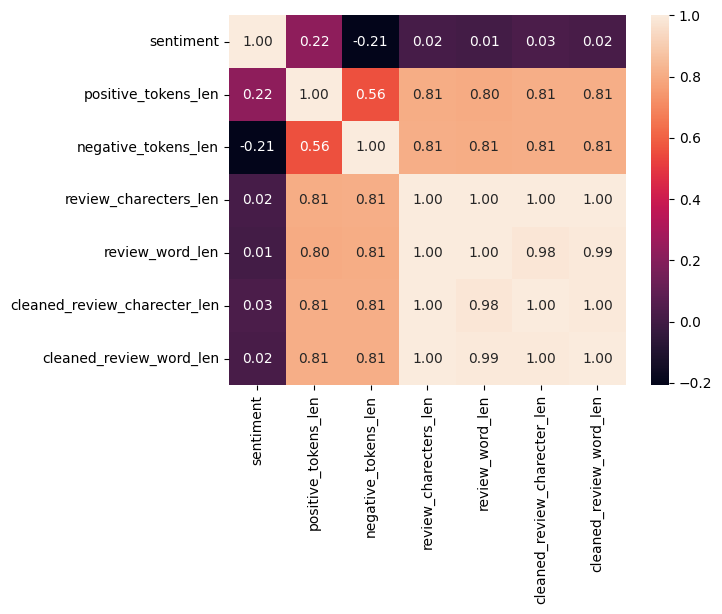

In [17]:
sns.heatmap(df[["sentiment", "positive_tokens_len","negative_tokens_len", 
                "review_charecters_len", "review_word_len", "cleaned_review_charecter_len", 
                "cleaned_review_word_len"]].corr(numeric_only=True), annot=True, fmt=".2f")
plt.show()

## Saving df

In [18]:
save_pickle(df, SAVE_DF_PATH)

## Count Vectorizer

In [19]:
countVecer = CountVectorizer(
    encoding='utf-8',                     # Character encoding (e.g., 'latin1' for non-UTF files)
    decode_error='strict',                # How to handle decode errors: 'strict', 'ignore', or 'replace'
    strip_accents=None,                   # 'ascii'/'unicode' removes accents (e.g., “café”→“cafe”)
    ngram_range=(1, 3),                   # Use unigrams only; (1,2) for unigrams + bigrams, etc.
    analyzer='word',                      # 'word' (default), 'char', or 'char_wb' for character n-grams
    max_df=1.0,                           # Ignore terms in >X% of docs (e.g., 0.9 removes common words)
    min_df=1,                             # Ignore terms in <X docs (e.g., 2 removes rare words)
    max_features=None,                    # Limit vocab size to top N most frequent tokens
    vocabulary=None,                      # Fixed vocabulary dict/list if you already know the terms
    binary=False,                         # If True, record presence (1/0) instead of counts
    dtype=float,                          # Type of matrix values (int, float, etc.)
)

In [20]:
r = df['cleaned_review'].sample(1)
countVectorized = countVecer.fit_transform(r)
r

45679    thought movie lacked building dramatic suspens...
Name: cleaned_review, dtype: object

In [21]:
countVectorized.get_shape(), countVectorized

((1, 193),
 <Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 193 stored elements and shape (1, 193)>)

In [22]:
countVecer.get_feature_names_out()

array(['accomplish', 'accomplish film', 'accomplish film take', 'amy',
       'amy irving', 'amy irving scene', 'another', 'another bring',
       'another bring involvement', 'apart', 'apart opening',
       'apart opening scene', 'best', 'best friend', 'best friend died',
       'bring', 'bring involvement', 'bring involvement amy', 'brought',
       'brought movie', 'brought movie pace', 'building',
       'building dramatic', 'building dramatic suspense', 'climatic',
       'climatic scene', 'climatic scene period', 'conclusion',
       'conclusion movie', 'conclusion movie could', 'could', 'could hit',
       'could hit fell', 'dialog', 'dialog movie',
       'dialog movie terrible', 'died', 'died funeral',
       'died funeral mentioned', 'dramatic', 'dramatic suspense',
       'dramatic suspense first', 'fell', 'fell apart',
       'fell apart opening', 'film', 'film movie', 'film movie went',
       'film take', 'film take place', 'final', 'final climatic',
       'final climat

In [23]:
pd.DataFrame(countVectorized.toarray(), columns=countVecer.get_feature_names_out())

,accomplish,accomplish film,accomplish film take,amy,amy irving,amy irving scene,another,another bring,another bring involvement,apart,...,way reflected way,week,week original,week original movie,went,went relatively,went relatively quickly,year,year still,year still less
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
countVecer = CountVectorizer(
    encoding=COUNT_ENCODING,             # Character encoding (e.g., 'latin1' for non-UTF files)
    decode_error=COUNT_DECODE_ERROR,     # How to handle decode errors: 'strict', 'ignore', or 'replace'
    strip_accents=COUNT_STRIP_ACCENTS,   # 'ascii'/'unicode' removes accents (e.g., “café”→“cafe”)
    ngram_range=COUNT_NGRAM_RANGE,       # Use unigrams only; (1,2) for unigrams + bigrams, etc.
    analyzer=COUNT_ANALYZER,             # 'word' (default), 'char', or 'char_wb' for character n-grams
    max_df=COUNT_MAX_DF,                 # Ignore terms in >X% of docs (e.g., 0.9 removes common words)
    min_df=COUNT_MIN_DF,                 # Ignore terms in <X docs (e.g., 2 removes rare words)
    max_features=COUNT_MAX_FEATURES,     # Limit vocab size to top N most frequent tokens
    vocabulary=COUNT_VOCABULARY,         # Fixed vocabulary dict/list if you already know the terms
    binary=COUNT_BINARY,                 # If True, record presence (1/0) instead of counts
    dtype=np.float32,                    # Type of matrix values (int, float, etc.)
)

In [25]:
countVectorized = countVecer.fit_transform(df["cleaned_review"])

In [26]:
countVectorized.shape, countVectorized.nnz

((50000, 20000), 5044360)

In [27]:
save_pickle(countVecer, COUNT_VECTORIZER_PATH)
save_npz(COUNT_MATRIX_PATH, countVectorized)

In [28]:
del countVectorized
del countVecer

## Tf-idf Vectorizer

In [29]:
tfidfVecer = TfidfVectorizer(
    encoding='utf-8',                     # Character encoding (e.g., 'latin1' for some older corpora)
    decode_error='strict',                # How to handle decode errors: 'strict', 'ignore', or 'replace'
    strip_accents=None,                   # 'ascii'/'unicode' removes accents (“café”→“cafe”)
    analyzer='word',                      # 'word' (default), 'char', or 'char_wb' (within word boundaries)
    ngram_range=(1, 3),                   # Use unigrams only; (1,2) for unigrams + bigrams, etc.
    max_df=1.0,                           # Ignore terms in >X% of docs (e.g., 0.9 removes very common words)
    min_df=1,                             # Ignore terms in <X docs (e.g., 2 removes very rare words)
    max_features=None,                    # Keep only the top N features by frequency
    vocabulary=None,                      # Fixed vocab list/dict (useful for applying same vocab later)
    binary=False,                         # If True, use 1/0 instead of term frequency before TF-IDF scaling
    dtype=np.float32,                     # Matrix value type (float32 or float64)
    norm='l2',                            # Normalize vectors: 'l1', 'l2', or None (no normalization)
    use_idf=True,                         # Enable inverse document frequency weighting
    smooth_idf=True,                      # Adds 1 to document frequencies to avoid div-by-zero
    sublinear_tf=False,                   # If True, use log(1 + tf) for term frequency scaling
)

In [30]:
r = df['cleaned_review'].sample(1)
tfidfVectorized = tfidfVecer.fit_transform(r)
r

8003    grew therefore must understand witnessed first...
Name: cleaned_review, dtype: object

In [31]:
tfidfVectorized.shape, tfidfVectorized.toarray(), tfidfVectorized

((1, 483),
 array([[0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.0805823 , 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.0805823 , 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.04029115, 0.04029115, 0.04029115, 0.04029115,
         0.04029115, 0.

In [32]:
tfidfVecer.get_feature_names_out()

array(['actor', 'actor older', 'actor older whatsoever', 'actually',
       'actually remember', 'actually remember part', 'ago',
       'ago character', 'ago character believable', 'airborne',
       'airborne possible', 'airborne possible dcoms', 'almost',
       'almost much', 'almost much zenon', 'always', 'always gay',
       'always gay feel', 'amount', 'amount excitement',
       'amount excitement zoog', 'apparently', 'apparently lack',
       'apparently lack curse', 'apparently type',
       'apparently type movie', 'appeared', 'appeared zenon',
       'appeared zenon halloweentown', 'around', 'around table',
       'around table asked', 'asked', 'asked seem', 'asked seem hip',
       'asking', 'asking always', 'asking always gay', 'awe', 'awe talk',
       'awe talk week', 'bad', 'bad effective', 'bad effective fact',
       'believable', 'believable funny', 'believable funny granted',
       'betrayed', 'betrayed could', 'betrayed could compare', 'brink',
       'brink appe

In [33]:
pd.DataFrame(tfidfVectorized.toarray(), columns=tfidfVecer.get_feature_names_out())

,actor,actor older,actor older whatsoever,actually,actually remember,actually remember part,ago,ago character,ago character believable,airborne,...,youngster ok,youngster ok maybe,zenon,zenon airborne,zenon airborne possible,zenon halloweentown,zenon halloweentown johnny,zoog,zoog disney,zoog disney brought
0,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291,...,0.040291,0.040291,0.080582,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291,0.040291


In [34]:
tfidfVecer = TfidfVectorizer(
    encoding=TFIDF_ENCODING,               # Character encoding (e.g., 'latin1' for some older corpora)
    decode_error=TFIDF_DECODE_ERROR,       # How to handle decode errors: 'strict', 'ignore', or 'replace'
    strip_accents=TFIDF_STRIP_ACCENTS,     # 'ascii'/'unicode' removes accents (“café”→“cafe”)
    analyzer=TFIDF_ANALYZER,               # 'word' (default), 'char', or 'char_wb' (within word boundaries)
    ngram_range=TFIDF_NGRAM_RANGE,         # Use unigrams only; (1,2) for unigrams + bigrams, etc.
    max_df=TFIDF_MAX_DF,                   # Ignore terms in >X% of docs (e.g., 0.9 removes very common words)
    min_df=TFIDF_MIN_DF,                   # Ignore terms in <X docs (e.g., 2 removes very rare words)
    max_features=TFIDF_MAX_FEATURES,       # Keep only the top N features by frequency
    vocabulary=TFIDF_VOCABULARY,           # Fixed vocab list/dict (useful for applying same vocab later)
    binary=TFIDF_BINARY,                   # If True, use 1/0 instead of term frequency before TF-IDF scaling
    dtype=np.float32,                      # Matrix value type (float32 or float64)
    norm=TFIDF_NORM,                       # Normalize vectors: 'l1', 'l2', or None (no normalization)
    use_idf=TFIDF_USE_IDF,                 # Enable inverse document frequency weighting
    smooth_idf=TFIDF_SMOOTH_IDF,           # Adds 1 to document frequencies to avoid div-by-zero
    sublinear_tf=TFIDF_SUBLINEAR_TF,       # If True, use log(1 + tf) for term frequency scaling
)

In [35]:
tfidfVectorized = tfidfVecer.fit_transform(df['cleaned_review'])

In [36]:
tfidfVectorized.shape, tfidfVectorized.nnz

((50000, 20000), 5044360)

In [37]:
save_pickle(tfidfVecer, TFIDF_VECTORIZER_PATH)
save_npz(TFIDF_MATRIX_PATH, tfidfVectorized)

In [38]:
del tfidfVectorized
del tfidfVecer

## Word to Vec models

### W2V

In [55]:
w2v = Word2Vec(sentences=df["tokens"].tolist(), vector_size=300, window=12, min_count=5, sg=1, epochs=12, workers=-1)

In [56]:
w2v.save('../models/w2v.model')

In [57]:
w2v.wv.most_similar('actor')

[('venal', 0.2541438341140747),
 ('downgrade', 0.22715307772159576),
 ('patiently', 0.2246485948562622),
 ('villain', 0.2235267460346222),
 ('wajda', 0.21494567394256592),
 ('flopped', 0.2106916904449463),
 ('century', 0.20911087095737457),
 ('arkin', 0.2081729620695114),
 ('grabbed', 0.20759066939353943),
 ('baptism', 0.206340491771698)]

In [58]:
w2v.wv.most_similar("good")

[('exotic', 0.2580218017101288),
 ('santo', 0.2481982558965683),
 ('blacksmith', 0.2310451716184616),
 ('langella', 0.2171274721622467),
 ('peed', 0.20839224755764008),
 ('undisputed', 0.2056414932012558),
 ('impressivei', 0.20323793590068817),
 ('circus', 0.2031862437725067),
 ('narrator', 0.2018582820892334),
 ('beneath', 0.1992671638727188)]

In [59]:
w2v.wv.most_similar(positive=["actor", "woman"], negative=["man"])

[('sockpuppet', 0.2528936564922333),
 ('chapter', 0.23831437528133392),
 ('cctv', 0.23643429577350616),
 ('taryn', 0.2180393934249878),
 ('tulsa', 0.21282437443733215),
 ('tighe', 0.21213021874427795),
 ('via', 0.2107212394475937),
 ('emotionalism', 0.21061818301677704),
 ('triggering', 0.208798348903656),
 ('wajda', 0.20826171338558197)]

In [60]:
w2v.wv.similarity("actor", "woman"), w2v.wv.similarity("actress", "woman") 

(np.float32(-0.06694317), np.float32(0.002177019))

In [61]:
r = w2v.wv['actor'] - w2v.wv['man'] + w2v.wv['woman']
w2v.wv.similar_by_vector(r)

[('actor', 0.571053683757782),
 ('woman', 0.5413703322410583),
 ('sockpuppet', 0.2535300552845001),
 ('cctv', 0.23859602212905884),
 ('chapter', 0.23852409422397614),
 ('taryn', 0.21920821070671082),
 ('tighe', 0.21226920187473297),
 ('tulsa', 0.21178434789180756),
 ('emotionalism', 0.2114517241716385),
 ('via', 0.2100626826286316)]

### FastText 

In [65]:
ft = FastText(sentences=df["tokens"].tolist(), vector_size=300, window=12, min_count=5, sg=1, epochs=1, workers=-1)

In [68]:
ft.save('../models/fasttext.model')

In [69]:
ft.wv.most_similar('smart')

[('outsmart', 0.5683782696723938),
 ('smarter', 0.5341701507568359),
 ('streetsmart', 0.5262489318847656),
 ('smartest', 0.5078085660934448),
 ('smartly', 0.47602853178977966),
 ('smartaleck', 0.4750869572162628),
 ('mart', 0.44146814942359924),
 ('smartass', 0.4342176914215088),
 ('kmart', 0.3593417704105377),
 ('smash', 0.3305506110191345)]

In [70]:
ft.wv.most_similar("good")

[('goody', 0.5411157011985779),
 ('goodas', 0.5270947217941284),
 ('goodif', 0.519572913646698),
 ('goodand', 0.48619481921195984),
 ('goodi', 0.4856874942779541),
 ('goodygoody', 0.4723361134529114),
 ('goode', 0.4678071439266205),
 ('goodthe', 0.45598605275154114),
 ('goodguy', 0.4541243314743042),
 ('aregood', 0.4537118077278137)]

In [71]:
ft.wv.most_similar(positive=["king", "girl"], negative=["boy"])

[('kingsleys', 0.32266560196876526),
 ('risktaking', 0.31349337100982666),
 ('kingsley', 0.31001219153404236),
 ('girlgirl', 0.29809537529945374),
 ('alltalking', 0.29413512349128723),
 ('girlie', 0.2794238030910492),
 ('talking', 0.25237298011779785),
 ('tarentino', 0.25110459327697754),
 ('releasing', 0.24939526617527008),
 ('girli', 0.24736759066581726)]

In [72]:
ft.wv.similarity("king", "girl"), w2v.wv.similarity("queen", "girl") 

(np.float32(0.0026288975), np.float32(-0.055612884))

In [73]:
r = ft.wv['king'] - ft.wv['boy'] + ft.wv['girl']
ft.wv.similar_by_vector(r)

[('king', 0.5123586654663086),
 ('girl', 0.46392184495925903),
 ('kingsleys', 0.30695071816444397),
 ('kingsley', 0.30032044649124146),
 ('risktaking', 0.29856494069099426),
 ('alltalking', 0.27565762400627136),
 ('girlgirl', 0.24969330430030823),
 ('tarentino', 0.24150341749191284),
 ('girlie', 0.23925212025642395),
 ('releasing', 0.23192457854747772)]